# NLP Data Preparation - yelp database

by Hugo Bertini @ 2020.08    
based on a [Yelp dataset](https://www.yelp.com/dataset) (_yelp_academic_dataset_covid_features.json_)<br>
referenced by [Women Who Code](https://www.womenwhocode.com/)    

## first we import the required libraries

In [1]:
# for the Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
import matplotlib.pyplot as plt # For visualizations
from wordcloud import WordCloud
from textblob import TextBlob
from textwrap import wrap
import pandas as pd
import string
import spacy
import json
import math
import re

## second, we load and inspect the data

In [2]:
df = pd.read_json('./data/yelp_academic_dataset_covid_features.json', lines=True)

In [3]:
df.head(10)

,business_id,highlights,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Covid Banner,Temporary Closed Until,Virtual Services Offered
0,9kXRUIkwdDtnAPO6tVo51g,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
1,H6D5HOTfMjrZt7r1EObZ1g,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,FYddq7fUtzobZcw4jOJgVA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,c75jLTjlgA9q3gImLEGT6w,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,YfzPiY50h_10Sjlg3mnNWQ,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
5,HqDRvA64BpGtjnzf9beE4Q,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
6,4voKpEbJhrhLv3FR__JgLA,"[{""identifier"":""remote_services_during_covid_1...",FALSE,FALSE,TRUE,TRUE,We are closely monitoring COVID-19 and adjusti...,FALSE,offers_virtual_tours
7,S-xZzaHeMyMcqf66GAC4wA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
8,c9sQmFjO8NnaLAFOVqWivw,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
9,64ZUb-llBHrnOcN_o1wA_A,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


### it looks like there is nested JSON in at least the highlights column. let's check it further:

In [4]:
print(df.loc[6, 'highlights'])
h_df = pd.json_normalize(json.loads(df.loc[6, 'highlights']))
h_df

[{"identifier":"remote_services_during_covid_19","params":{},"type":"covid"},{"identifier":"24_7_availability","params":{},"type":"availability"},{"identifier":"available_by_appointment","params":{},"type":"availability"},{"identifier":"wheelchair_accessible","params":{},"type":"amenities"}]


,identifier,type
0,remote_services_during_covid_19,covid
1,24_7_availability,availability
2,available_by_appointment,availability
3,wheelchair_accessible,amenities


In [5]:
h_df.loc[:, 'type']

0           covid
1    availability
2    availability
3       amenities
Name: type, dtype: object

In [6]:
highlight_types = ''
highlight_types = h_df.loc[:, 'type'].to_dict()
highlight_types = list(dict((v, k) for k, v in highlight_types.items()))
print(highlight_types)

['covid', 'availability', 'amenities']


In [7]:
highlight_identifiers = ''
highlight_identifiers = h_df.loc[:, 'identifier'].to_dict()
highlight_identifiers = list(dict((v, k) for k, v in highlight_identifiers.items()))
print(highlight_identifiers)

['remote_services_during_covid_19', '24_7_availability', 'available_by_appointment', 'wheelchair_accessible']


In [8]:
def get_value_list(jsn, col):
    """
    gets a json string and a column name. 
    returns a list of unique values present 
    in that column of the given dataframe
    if something goes wrong, returns an empty list
    """
    col_values = []
    try:
        df_jsn = pd.json_normalize(json.loads(jsn))
        col_values = df_jsn.loc[:, col].to_dict()
        col_values = list(dict((v, k) for k, v in col_values.items()))
    except:
        pass
        #print('get_value_list: unable to retrieve values for . returning empty list.')
    return col_values

In [9]:
# highlights with potentially valid information
display(
    df[
        (df['highlights'].str.len() > 5)
        |
        (df['Covid Banner'].str.len() > 5)
        |
        (df['Virtual Services Offered'].str.len() > 5)
    ]
)

# delivery or takeout values
display(df['delivery or takeout'].value_counts())

# Grubhub enabled values
display(df['Grubhub enabled'].value_counts())


,business_id,highlights,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Covid Banner,Temporary Closed Until,Virtual Services Offered
6,4voKpEbJhrhLv3FR__JgLA,"[{""identifier"":""remote_services_during_covid_1...",FALSE,FALSE,TRUE,TRUE,We are closely monitoring COVID-19 and adjusti...,FALSE,offers_virtual_tours
172,UIvxNM7ACHq_sxzf83oN8A,FALSE,FALSE,FALSE,TRUE,FALSE,As Nevada eases restrictions on small business...,FALSE,offers_virtual_tours
173,UIvxNM7ACHq_sxzf83oN8A,FALSE,FALSE,FALSE,TRUE,FALSE,As Nevada eases restrictions on small business...,FALSE,offers_virtual_consultations
180,nzq_S0Y55kEME7KSgHQ9iw,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,offers_virtual_consultations
225,_RmXcOK6jks4VUOC5-pyBg,"[{""identifier"":""remote_services_during_covid_1...",FALSE,FALSE,TRUE,TRUE,Mark-Taylor is dedicated to the safety of our ...,FALSE,FALSE
...,...,...,...,...,...,...,...,...,...
209759,W3VPhkcoJd7kjYPq5WiRPw,FALSE,FALSE,FALSE,TRUE,FALSE,Business operations may be affected by ongoing...,FALSE,FALSE
209767,IsoLzudHC50oJLiEWpwV-w,"[{""identifier"":""gift_cards_during_covid_19"",""p...",TRUE,TRUE,TRUE,FALSE,Chelsea's Kitchen is excited to be welcoming b...,FALSE,FALSE
209771,QxXPce5JJoFkJbME_Y6_0w,"[{""identifier"":""remote_services_during_covid_1...",FALSE,FALSE,TRUE,FALSE,Our office is committed to continuing to opera...,FALSE,FALSE
209775,6rn0T5xTHgE5Enyi9obeaw,"[{""identifier"":""curbside_drop_off_during_covid...",FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE


FALSE    143564
TRUE      66231
Name: delivery or takeout, dtype: int64

FALSE    191802
TRUE      17993
Name: Grubhub enabled, dtype: int64

## third, we clean and wrangle the data

flattening the information in the 'highlights' column:

In [10]:
df.loc[:, 'highlight_types'] = df.loc[:, 'highlights'].apply(get_value_list, col='type')
df.loc[:, 'highlight_params'] = df.loc[:, 'highlights'].apply(get_value_list, col='params')
df.loc[:, 'highlight_identifier'] = df.loc[:, 'highlights'].apply(get_value_list, col='identifier')

In [11]:
df

,business_id,highlights,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Covid Banner,Temporary Closed Until,Virtual Services Offered,highlight_types,highlight_params,highlight_identifier
0,9kXRUIkwdDtnAPO6tVo51g,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,[],[],[]
1,H6D5HOTfMjrZt7r1EObZ1g,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,[],[],[]
2,FYddq7fUtzobZcw4jOJgVA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,[],[],[]
3,c75jLTjlgA9q3gImLEGT6w,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,[],[],[]
4,YfzPiY50h_10Sjlg3mnNWQ,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
209790,PAuSe4-JzDLq6YO6OKPeTg,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,[],[],[]
209791,GQEe9qAe2alEA1zzRzUr0w,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,[],[],[]
209792,T-PWmMvktw0nMNO4N5XLXA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,[],[],[]
209793,stVu6q5hDxQuppwoo6m0EQ,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,[],[],[]


## This dataset has a lot of interesting information that could be crosso analysed. However, for the sake of natural language data preparation, we will stick to the business_id and Covid Banner columns:

In [12]:
df = df.loc[:, ['business_id', 'Covid Banner']]
df = df[df['Covid Banner'].str.len() > 5]
#df = df.drop_duplicates(subset=['Covid Banner']).reset_index(drop=True)
df

,business_id,Covid Banner
6,4voKpEbJhrhLv3FR__JgLA,We are closely monitoring COVID-19 and adjusti...
172,UIvxNM7ACHq_sxzf83oN8A,As Nevada eases restrictions on small business...
173,UIvxNM7ACHq_sxzf83oN8A,As Nevada eases restrictions on small business...
225,_RmXcOK6jks4VUOC5-pyBg,Mark-Taylor is dedicated to the safety of our ...
423,9S_1SghocMYzn9e0J18-WA,Stay at home and we'll come to you. Delivery o...
...,...,...
209737,cLcx7gIyvLn7oGwq8jp6ng,We've made the difficult decision to temporari...
209759,W3VPhkcoJd7kjYPq5WiRPw,Business operations may be affected by ongoing...
209767,IsoLzudHC50oJLiEWpwV-w,Chelsea's Kitchen is excited to be welcoming b...
209771,QxXPce5JJoFkJbME_Y6_0w,Our office is committed to continuing to opera...


In [13]:
df['Covid Banner'].value_counts()

Most stores open 9am-9pm weekdays. Seniors-only hour is 8am-9am every Tuesday. Many new services offered during COVID-19. For everyone's safety, we've updated our hours to allow for extra cleaning and stocking. Most stores are open 9am-9pm weekdays. 24-hour stores are drive-thru only overnight 9pm-9am.   *Free Next Day Rx Delivery-- Use Walgreens Express and get eligible prescriptions delivered  to your door. Text JoinRx to 21525 to sign up. Message and Data Rates May Apply.  *Get products delivered today-- Now you can order Walgreens items with Postmates and get same-day delivery.  *Drive-Thru Shopping-- Use the drive-thru to safely pick up Rx & select essentials.  *Free Shipping, No Minimum-- Shop online and get essentials shipped to your home free, no minimum purchase required.  *Feeling Sick? Find Care Online--Stay home and consult with a healthcare provider online: walgreens.com/findcare.                                                            311
Taco Bell restaurants are taki

### Expanding contractions, lowercasing, removing digits, punctuations and extra spaces

In [14]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

In [15]:
# lowercasing
df.loc[:, 'Covid Banner'] = df.loc[:, 'Covid Banner'].str.lower()


In [16]:
df['Covid Banner'] = df['Covid Banner'].apply(lambda x: expand_contractions(x))

df

,business_id,Covid Banner
6,4voKpEbJhrhLv3FR__JgLA,we are closely monitoring covid-19 and adjusti...
172,UIvxNM7ACHq_sxzf83oN8A,as nevada eases restrictions on small business...
173,UIvxNM7ACHq_sxzf83oN8A,as nevada eases restrictions on small business...
225,_RmXcOK6jks4VUOC5-pyBg,mark-taylor is dedicated to the safety of our ...
423,9S_1SghocMYzn9e0J18-WA,stay at home and we will come to you. delivery...
...,...,...
209737,cLcx7gIyvLn7oGwq8jp6ng,we have made the difficult decision to tempora...
209759,W3VPhkcoJd7kjYPq5WiRPw,business operations may be affected by ongoing...
209767,IsoLzudHC50oJLiEWpwV-w,chelsea is kitchen is excited to be welcoming ...
209771,QxXPce5JJoFkJbME_Y6_0w,our office is committed to continuing to opera...


In [17]:
# removing digits and words with digits
df.loc[:, 'Covid Banner'] = df.loc[:, 'Covid Banner'].apply(lambda x: re.sub('\w*\d\w*', '', x))
# removing punctuations
df.loc[:, 'Covid Banner'] = df.loc[:, 'Covid Banner'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# removing extra spaces
df.loc[:, 'Covid Banner'] = df.loc[:, 'Covid Banner'].apply(lambda x: re.sub(' +', ' ', x))
df

,business_id,Covid Banner
6,4voKpEbJhrhLv3FR__JgLA,we are closely monitoring covid and adjusting ...
172,UIvxNM7ACHq_sxzf83oN8A,as nevada eases restrictions on small business...
173,UIvxNM7ACHq_sxzf83oN8A,as nevada eases restrictions on small business...
225,_RmXcOK6jks4VUOC5-pyBg,marktaylor is dedicated to the safety of our s...
423,9S_1SghocMYzn9e0J18-WA,stay at home and we will come to you delivery ...
...,...,...
209737,cLcx7gIyvLn7oGwq8jp6ng,we have made the difficult decision to tempora...
209759,W3VPhkcoJd7kjYPq5WiRPw,business operations may be affected by ongoing...
209767,IsoLzudHC50oJLiEWpwV-w,chelsea is kitchen is excited to be welcoming ...
209771,QxXPce5JJoFkJbME_Y6_0w,our office is committed to continuing to opera...


## Preparation for EDA

### Stopwords Removal and Lemmatization

In [18]:
# Loading model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [19]:
# Lemmatization with stopwords removal
df['lemmatized']=df['Covid Banner'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [20]:
df

,business_id,Covid Banner,lemmatized
6,4voKpEbJhrhLv3FR__JgLA,we are closely monitoring covid and adjusting ...,closely monitor covid adjust business importan...
172,UIvxNM7ACHq_sxzf83oN8A,as nevada eases restrictions on small business...,nevada ease restriction small business health ...
173,UIvxNM7ACHq_sxzf83oN8A,as nevada eases restrictions on small business...,nevada ease restriction small business health ...
225,_RmXcOK6jks4VUOC5-pyBg,marktaylor is dedicated to the safety of our s...,marktaylor dedicate safety staff community cri...
423,9S_1SghocMYzn9e0J18-WA,stay at home and we will come to you delivery ...,stay home come delivery online order free exte...
...,...,...,...
209737,cLcx7gIyvLn7oGwq8jp6ng,we have made the difficult decision to tempora...,difficult decision temporarily close scoop sho...
209759,W3VPhkcoJd7kjYPq5WiRPw,business operations may be affected by ongoing...,business operation affect ongoe precautionary ...
209767,IsoLzudHC50oJLiEWpwV-w,chelsea is kitchen is excited to be welcoming ...,chelsea kitchen excited welcome loyal guest mo...
209771,QxXPce5JJoFkJbME_Y6_0w,our office is committed to continuing to opera...,office commit continue operate patient emergen...


In [21]:
df.groupby('business_id').head()

,business_id,Covid Banner,lemmatized
6,4voKpEbJhrhLv3FR__JgLA,we are closely monitoring covid and adjusting ...,closely monitor covid adjust business importan...
172,UIvxNM7ACHq_sxzf83oN8A,as nevada eases restrictions on small business...,nevada ease restriction small business health ...
173,UIvxNM7ACHq_sxzf83oN8A,as nevada eases restrictions on small business...,nevada ease restriction small business health ...
225,_RmXcOK6jks4VUOC5-pyBg,marktaylor is dedicated to the safety of our s...,marktaylor dedicate safety staff community cri...
423,9S_1SghocMYzn9e0J18-WA,stay at home and we will come to you delivery ...,stay home come delivery online order free exte...
...,...,...,...
209737,cLcx7gIyvLn7oGwq8jp6ng,we have made the difficult decision to tempora...,difficult decision temporarily close scoop sho...
209759,W3VPhkcoJd7kjYPq5WiRPw,business operations may be affected by ongoing...,business operation affect ongoe precautionary ...
209767,IsoLzudHC50oJLiEWpwV-w,chelsea is kitchen is excited to be welcoming ...,chelsea kitchen excited welcome loyal guest mo...
209771,QxXPce5JJoFkJbME_Y6_0w,our office is committed to continuing to opera...,office commit continue operate patient emergen...


In [22]:
df_grouped = df[['business_id', 'lemmatized']].groupby('business_id').agg(lambda x: ' '.join(x))
df_grouped.reset_index(drop=True)

,lemmatized
0,pinnacle restoration take precaution outbreak ...
1,location open ready welcome learn safe clean p...
2,open takeout delivery follow guideline custome...
3,difficult time decide action temporarily close...
4,sport clip location officially open business v...
...,...
13678,work hard provide safe solution continue off...
13679,store open weekday seniorsonly hour tuesday ne...
13680,offer human contact car repair sanitization
13681,carhartt exist serve protect hardworking peopl...


## Sentiment Analysis

In [23]:
df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [24]:
df_pol = df.loc[df['polarity'].sort_values(ascending=False).index]
df_pol.head(30)

,business_id,Covid Banner,lemmatized,polarity
105252,HwfEGNYgE0UZ3aHgCTQCfw,to our wonderful customers we are limiting our...,wonderful customer limit hour day operation co...,1.00
67087,AyOKFrLeuFCp9CzGDB_qYw,we look forward to reopening our doors soon to...,look forward reopen door soon serve delicious ...,1.00
47384,0Ns7W6otC5xBniWBy8JzHQ,we look forward to reopening our doors soon to...,look forward reopen door soon serve delicious ...,1.00
38154,B-4DRFEDLpwyW8mXNwzzjQ,we look forward to reopening our doors soon to...,look forward reopen door soon serve delicious ...,1.00
137916,_M2gJVqPWMSnkbZ0q_jBEw,here at ac doctors we are committed to the saf...,ac doctor committed safety family technician t...,1.00
94771,T2cNRwgFxTxVVMPN66BZoA,during this time we are now practicing self di...,time practice self distancing offer delivery s...,1.00
45051,I-SRnzhQb0WU-2HrZ8u3qA,we look forward to reopening our doors soon to...,look forward reopen door soon serve delicious ...,1.00
199115,C1N64o06aM1ETOxDebhrbw,we look forward to reopening our doors soon to...,look forward reopen door soon serve delicious ...,1.00
97839,WOiTUlxOsACXdzbrvOntrQ,our restaurant reopened on may restaurants lim...,restaurant reopen restaurant limit number dine...,0.85
111213,t0GGr0P4Gvu4S7ne_79AsA,we are reopen on monday please book us online ...,reopen monday book online follow instagram lun...,0.85


### Create Document Term Matrix

In [25]:
cv=CountVectorizer(analyzer='word')

In [26]:
data1 = cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data1.toarray(), columns=cv.get_feature_names())
df_dtm.index = df_grouped.index
df_dtm

,aafe,aall,aao,aaron,aas,ab,abbreviate,abide,abiertas,abiertos,...,œstay,œtravel,œwindow,œâ,œé,œð,œðÿ,šð,žï,žð
business_id,,,,,,,,,,,,,,,,,,,,,
--Y7NhBKzLTbNliMUX_wfg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--ab39IjZR_xUf81WyTyHg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--cZ6Hhc9F7VkKXxHMVZSQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--cjBEbXMI2obtaRHNSFrA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0GU6ghA7z4-xotUZfXl1w,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyT1smf2oJwimXKAS6GX0Q,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zygi_qdda2P2671LnK5dPw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zyh99Jf6y2wXKNrOvaXaAQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

### Word Clouds

In [27]:
# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150, background_color='White', colormap="Set2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()


In [28]:
# Transposing document term matrix
df_dtm_t=df_dtm.transpose()

In [29]:
df_dtm_t.head()

business_id,--Y7NhBKzLTbNliMUX_wfg,--ab39IjZR_xUf81WyTyHg,--cZ6Hhc9F7VkKXxHMVZSQ,--cjBEbXMI2obtaRHNSFrA,-0GU6ghA7z4-xotUZfXl1w,-0lbeUxS9QDBtIS5KtPKZw,-1VaIJza42Hjev6ukacCNg,-28hEE6AcAUbJctGwvC9kw,-2HjuT4yjLZ3b5f_abD87Q,-2WsPmC49gP3RRk2UUUmpQ,...,zx7jtkTgznKMh388hP8Spw,zx_j6OuuHHa2afVoAZuLpA,zxzG2WLlxcxGyTmGtL5Bsw,zy2OT5gpcsr_p553LdPvvA,zyPGYeXF4XKCqNN1pjFWhg,zyT1smf2oJwimXKAS6GX0Q,zygi_qdda2P2671LnK5dPw,zyh99Jf6y2wXKNrOvaXaAQ,zyj1g82GHSyDYmPX1zkn0Q,zztHqd_3ULxuIS8lkhYdwg
aafe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aall,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aao,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaron,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
top_sentiment_b_ids = df_pol.iloc[:10]['business_id']
bottom_sentiment_b_ids = df_pol.iloc[-10:]['business_id']

## Top Sentiment COVID Banners

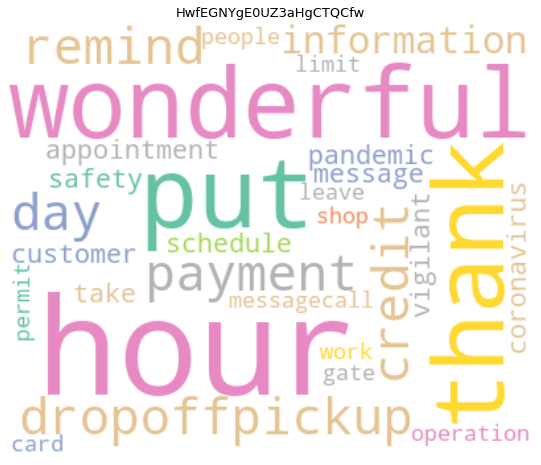

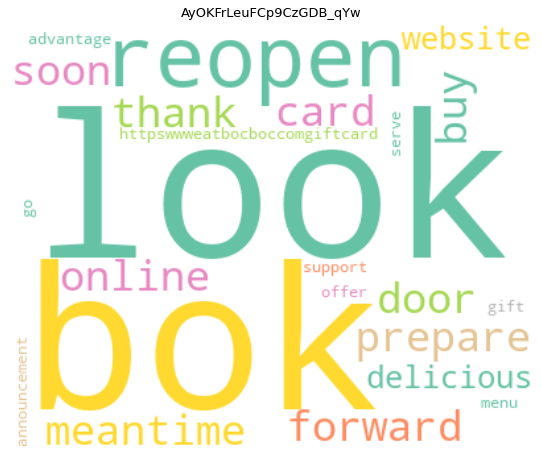

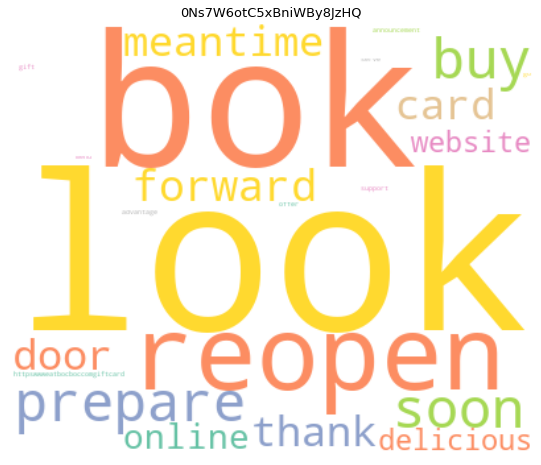

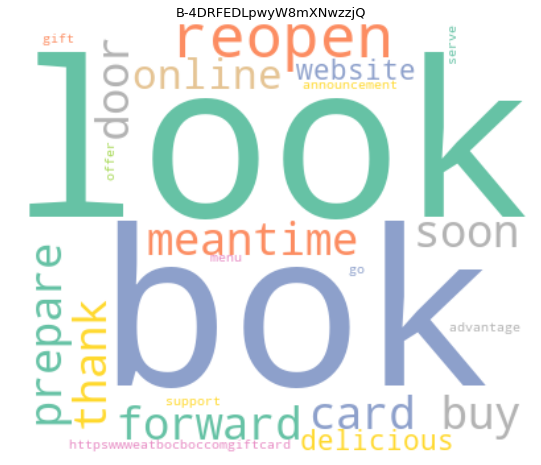

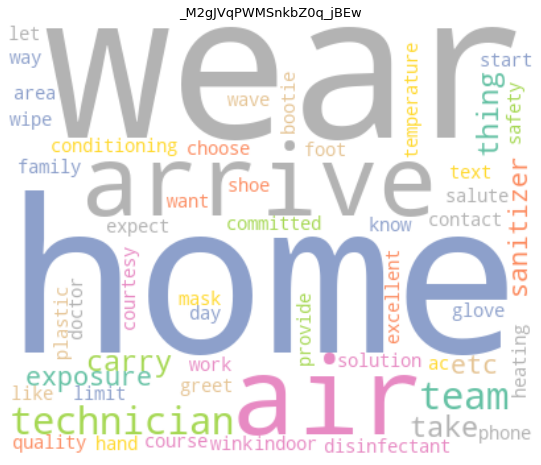

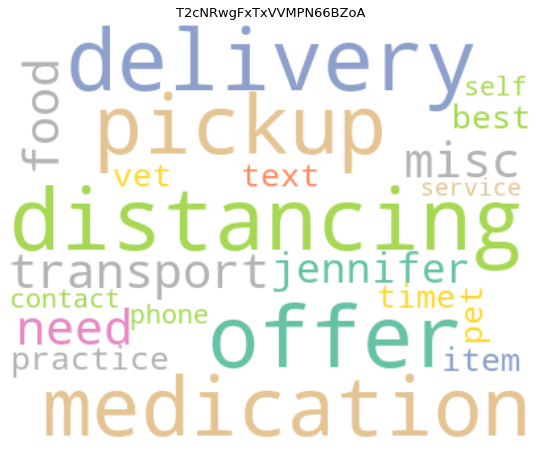

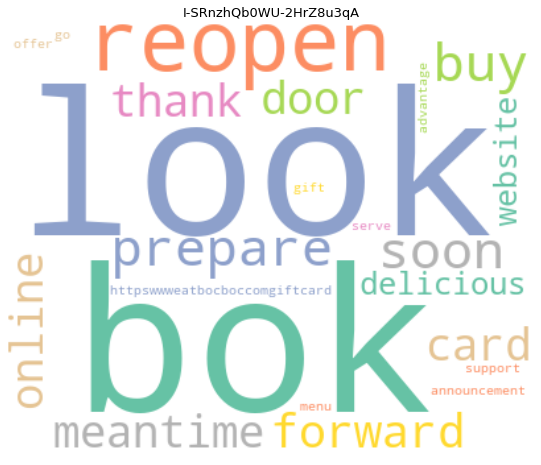

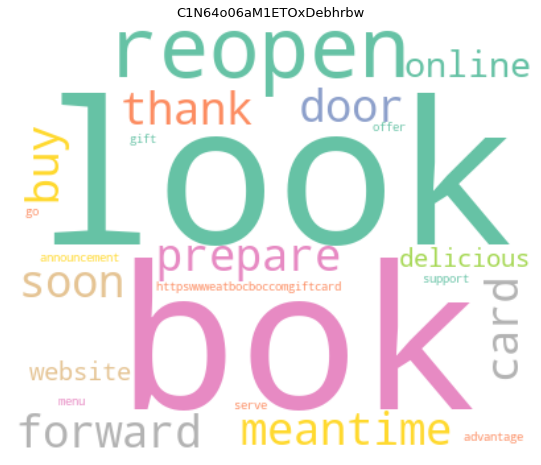

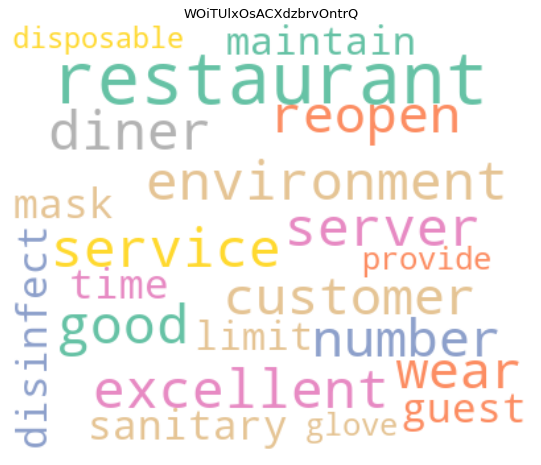

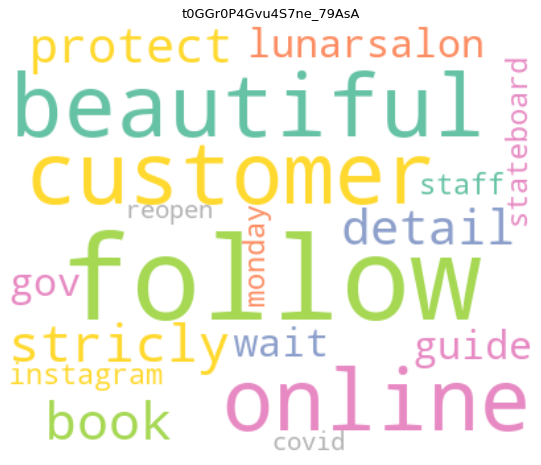

In [37]:
# Plotting word cloud for the business_ids with top sentiment
for index, banner in enumerate(df_dtm_t[top_sentiment_b_ids].columns):
    generate_wordcloud(df_dtm_t[banner].sort_values(ascending=False),banner)

## Bottom Sentiment COVID Banners

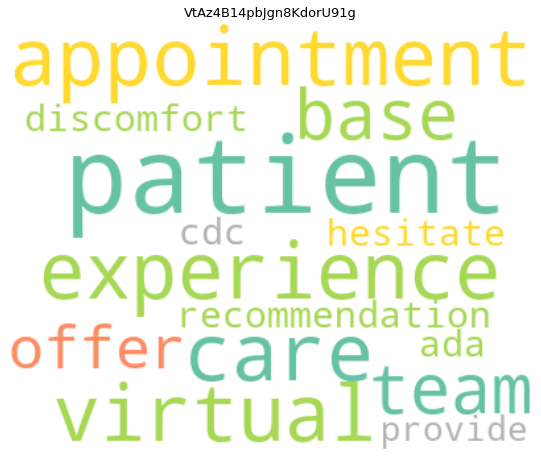

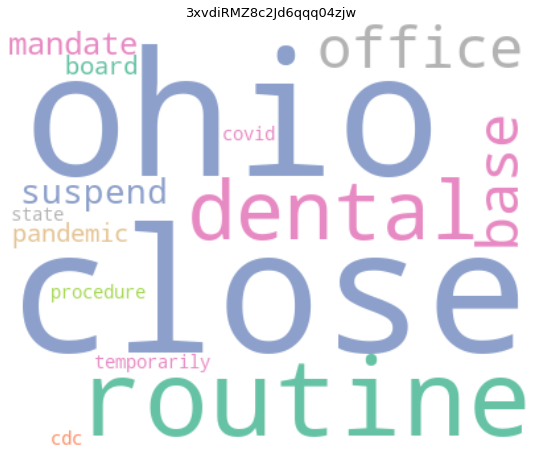

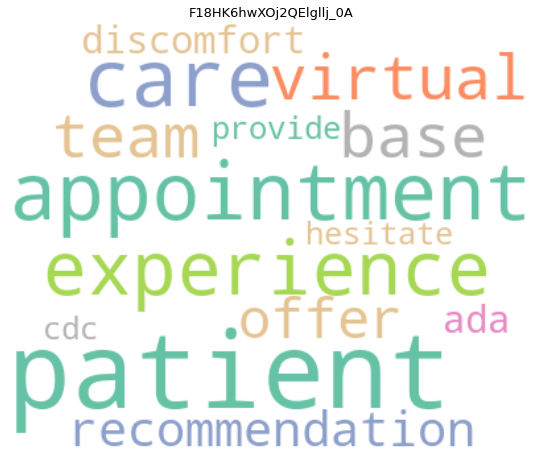

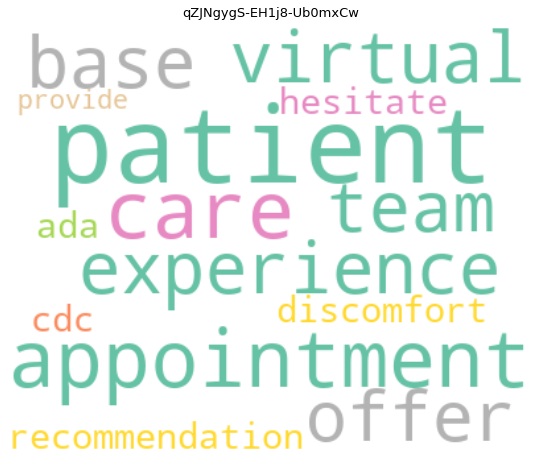

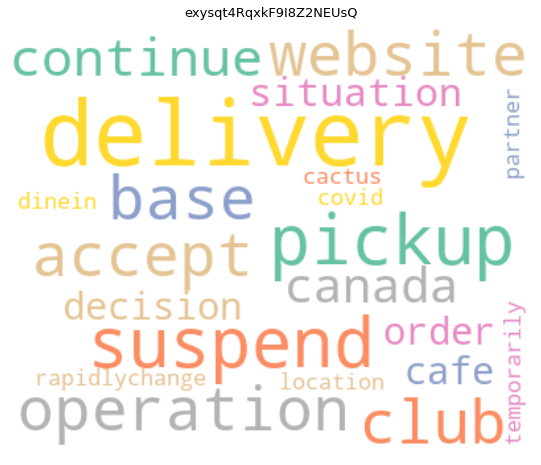

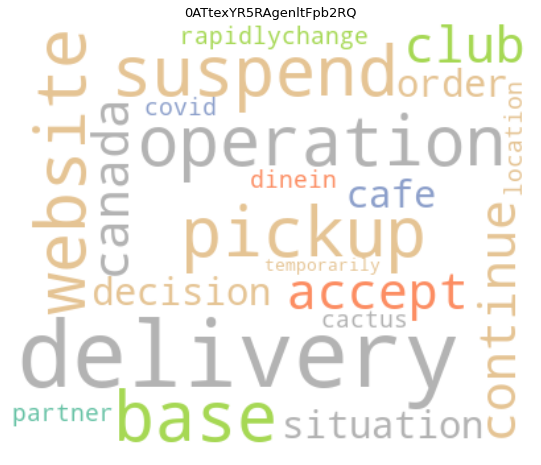

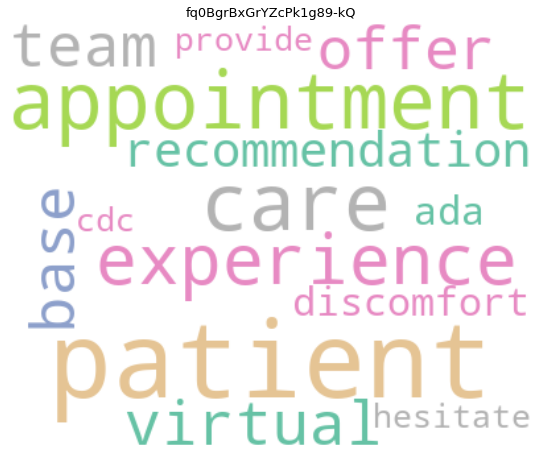

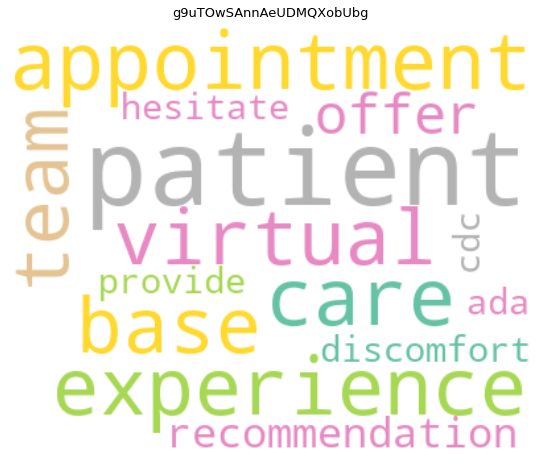

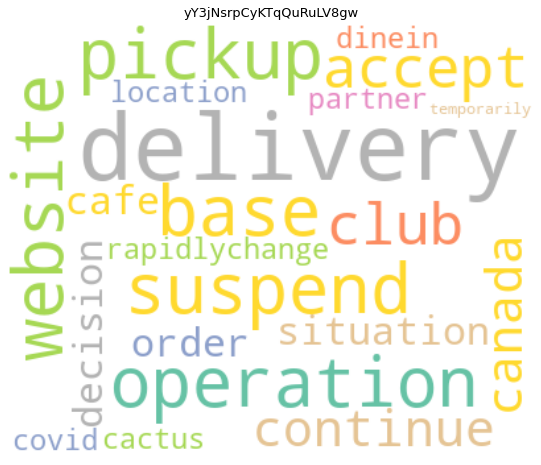

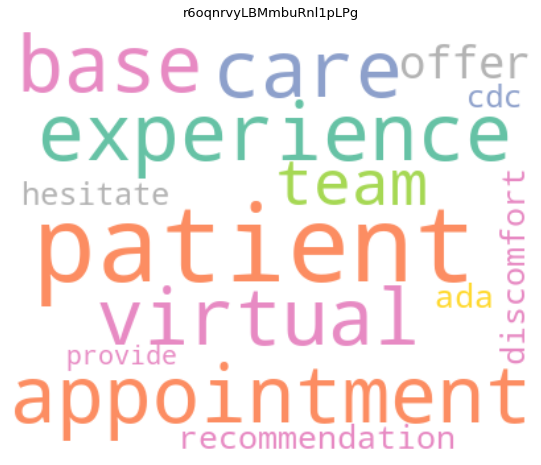

In [38]:
# Plotting word cloud for the business_ids with top sentiment
for index, banner in enumerate(df_dtm_t[bottom_sentiment_b_ids].columns):
    generate_wordcloud(df_dtm_t[banner].sort_values(ascending=False),banner)